In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
from sklearn.linear_model import ElasticNet, HuberRegressor
from sklearn.ensemble import HistGradientBoostingRegressor

In [3]:
def build_model_frame(df):
    """
    Create a leak-free modeling frame for forecasting dwelling_starts per province.

    Parameters
    ----------
    df : pandas.DataFrame
        Must contain at least: 'quarter', 'province',
        'dwelling_starts', 'pop_change_q', 'needed_units_q'

    Returns
    -------
    model_df : pandas.DataFrame
        Long-form table with lag features, ready for modeling.
    """
    # sort to guarantee time order within each province
    df = df.sort_values(["province", "quarter"]).copy()

    # target
    df["y"] = df["dwelling_starts"]

    # same-quarter-last-year lag (4 quarters back) for the seasonal baseline model (if i want to forecast same q next year)
    for col in ["dwelling_starts", "pop_change_q", "needed_units_q"]:
        df[f"{col}_lag4"] = df.groupby("province")[col].shift(4)

    '''# same-quarter-last-year lag (4 quarters back) for the seasonal baseline model (if i want to forecast same q next year)
    df["dwelling_starts_lag4"] = df.groupby("province")["dwelling_starts"].shift(4)
'''
    # drop rows where any lag is missing (first few quarters per province)
    feat_cols = [
        "dwelling_starts_lag4",
         "needed_units_q_lag4"
    ]
    model_df = df.dropna(subset=["y"] + feat_cols).reset_index(drop=True)

    return model_df, feat_cols


In [4]:
df = pd.read_csv('data/housing_adequacy_dataset.csv')

model_df, feat_cols = build_model_frame(df)

In [29]:
model_df

,quarter,province,population,starts_saar,starts_saar_q,dwelling_starts,pop_change_q,needed_units_q,hai,y,dwelling_starts_lag4,pop_change_q_lag4,needed_units_q_lag4
0,1991-04-01,ab,2580625.0,12.852333,3.213083,3213.083333,7678.0,3071.2,1.046198,3213.083333,5372.583333,12565.0,5026.0
1,1991-07-01,ab,2592306.0,13.536333,3.384083,3384.083333,11681.0,4672.4,0.724271,3384.083333,3461.750000,15167.0,6066.8
2,1991-10-01,ab,2604031.0,14.018000,3.504500,3504.500000,11725.0,4690.0,0.747228,3504.500000,2930.833333,15354.0,6141.6
3,1992-01-01,ab,2611786.0,16.100333,4.025083,4025.083333,7755.0,3102.0,1.297577,4025.083333,2123.666667,9805.0,3922.0
4,1992-04-01,ab,2620771.0,17.638333,4.409583,4409.583333,8985.0,3594.0,1.226929,4409.583333,3213.083333,7678.0,3071.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1513,2024-07-01,sk,1247868.0,5.716333,1.429083,1429.083333,9277.0,3710.8,0.385115,1429.083333,1263.000000,8633.0,3453.2
1514,2024-10-01,sk,1256983.0,4.590667,1.147667,1147.666667,9115.0,3646.0,0.314774,1147.666667,1316.833333,11895.0,4758.0
1515,2025-01-01,sk,1261524.0,6.101667,1.525417,1525.416667,4541.0,1816.4,0.839802,1525.416667,840.583333,8164.0,3265.6
1516,2025-04-01,sk,1264537.0,6.118667,1.529667,1529.666667,3013.0,1205.2,1.269222,1529.666667,883.333333,8275.0,3310.0


In [5]:
model_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1518 entries, 0 to 1517
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   quarter               1518 non-null   object 
 1   province              1518 non-null   object 
 2   population            1518 non-null   float64
 3   starts_saar           1518 non-null   float64
 4   starts_saar_q         1518 non-null   float64
 5   dwelling_starts       1518 non-null   float64
 6   pop_change_q          1518 non-null   float64
 7   needed_units_q        1518 non-null   float64
 8   hai                   1491 non-null   float64
 9   y                     1518 non-null   float64
 10  dwelling_starts_lag4  1518 non-null   float64
 11  pop_change_q_lag4     1518 non-null   float64
 12  needed_units_q_lag4   1518 non-null   float64
dtypes: float64(11), object(2)
memory usage: 154.3+ KB


In [6]:
feat_cols

['dwelling_starts_lag4', 'needed_units_q_lag4']

In [7]:
#checking and converting the quarter to datetime if it was object before
if model_df["quarter"].dtype == "O":
    model_df['quarter'] = pd.PeriodIndex(model_df['quarter'], freq='Q').to_timestamp()

In [30]:
model_df

,quarter,province,population,starts_saar,starts_saar_q,dwelling_starts,pop_change_q,needed_units_q,hai,y,dwelling_starts_lag4,pop_change_q_lag4,needed_units_q_lag4
0,1991-04-01,ab,2580625.0,12.852333,3.213083,3213.083333,7678.0,3071.2,1.046198,3213.083333,5372.583333,12565.0,5026.0
1,1991-07-01,ab,2592306.0,13.536333,3.384083,3384.083333,11681.0,4672.4,0.724271,3384.083333,3461.750000,15167.0,6066.8
2,1991-10-01,ab,2604031.0,14.018000,3.504500,3504.500000,11725.0,4690.0,0.747228,3504.500000,2930.833333,15354.0,6141.6
3,1992-01-01,ab,2611786.0,16.100333,4.025083,4025.083333,7755.0,3102.0,1.297577,4025.083333,2123.666667,9805.0,3922.0
4,1992-04-01,ab,2620771.0,17.638333,4.409583,4409.583333,8985.0,3594.0,1.226929,4409.583333,3213.083333,7678.0,3071.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1513,2024-07-01,sk,1247868.0,5.716333,1.429083,1429.083333,9277.0,3710.8,0.385115,1429.083333,1263.000000,8633.0,3453.2
1514,2024-10-01,sk,1256983.0,4.590667,1.147667,1147.666667,9115.0,3646.0,0.314774,1147.666667,1316.833333,11895.0,4758.0
1515,2025-01-01,sk,1261524.0,6.101667,1.525417,1525.416667,4541.0,1816.4,0.839802,1525.416667,840.583333,8164.0,3265.6
1516,2025-04-01,sk,1264537.0,6.118667,1.529667,1529.666667,3013.0,1205.2,1.269222,1529.666667,883.333333,8275.0,3310.0


## Data splitting

In [8]:
def chrono_split(df, cutoff="2018-12-31"):
    
    cutoff = pd.Timestamp(cutoff)
    tr = df[df["quarter"] <= cutoff].copy()
    te = df[df["quarter"] >  cutoff].copy()
    return tr, te

"""
    Expanding-window backtest.
      - initial: first train end date (Timestamp or str). If None, uses 60% of timeline.
      - step: how many quarters to advance the train end each fold.
      - fh: forecast horizon in quarters (size of the test slice each fold).
    Yields (train_df, test_df) pairs over the whole *panel* (all provinces).
"""
def rolling_split(df,
                  initial=None,
                  step=1,
                  fh=2):
 
    dates = np.sort(df["quarter"].unique())
    if initial is None:
        initial = dates[int(0.6 * len(dates))]
    else:
        initial = pd.Timestamp(initial)

    # find index of initial in the date array
    # (if not exact, snap to the nearest past available quarter)
    start_idx = np.searchsorted(dates, initial, side="right") - 1
    start_idx = max(start_idx, 0)

    for i in range(start_idx, len(dates) - fh, step):
        train_end = dates[i]
        test_slice = dates[i+1 : i+1+fh]
        tr = df[df["quarter"] <= train_end].copy()
        te = df[df["quarter"].isin(test_slice)].copy()
        if not te.empty:
            yield tr, te

In [9]:
def metrics(y_true, y_pred):
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    eps = 1e-8 #to avoid a zero denominator
    smape = 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + eps))
    return {"MAE": mae, "RMSE": rmse, "sMAPE": smape}

def metrics_by_province(test_df, target_col="dwelling_starts", pred_col="dwelling_starts_lag4"):
    rows = []
    for prov, g in test_df.groupby("province"):
        y_true = g[target_col]
        y_pred = g[pred_col]
        res = metrics(y_true, y_pred)
        res["province"] = prov
        rows.append(res)
    return pd.DataFrame(rows).set_index("province")


In [10]:
def mase(y_true, y_pred, y_train, season=4):
    """Mean Absolute Scaled Error (compare to naive lag=season)."""
    # Naive forecast errors on the training set
    naive_forecast = y_train.shift(season)
    mae_naive = np.mean(np.abs(y_train[season:] - naive_forecast[season:]))
    
    # Model forecast errors on the test set
    mae_model = np.mean(np.abs(y_true - y_pred))
    
    return mae_model / mae_naive

In [11]:
train, test = chrono_split(model_df)
#metrics for the seasonal naive where last quarter's data is used as last year’s same-quarter value as a guess for this year’s quarter.
prov_metrics_naive = metrics_by_province(test) 
print(prov_metrics_naive)
print("\nAverage across provinces:", prov_metrics_naive.mean())

                  MAE         RMSE      sMAPE
province                                     
ab        1782.408951  2162.125549  20.991820
bc        1801.922840  2284.144857  16.041829
can       6596.925926  8487.884270  11.105641
mb         382.628086   453.137477  20.182308
nb         232.004630   278.693660  23.497553
nl         122.373457   170.446232  38.874957
ns         530.064815   696.789010  33.116392
on        3619.155864  4075.384725  17.589695
pe          80.932099   106.172626  27.764746
qc        3099.731481  3820.479754  23.710687
sk         286.061728   344.776711  29.349457

Average across provinces: MAE      1684.928171
RMSE     2080.003170
sMAPE      23.838644
dtype: float64


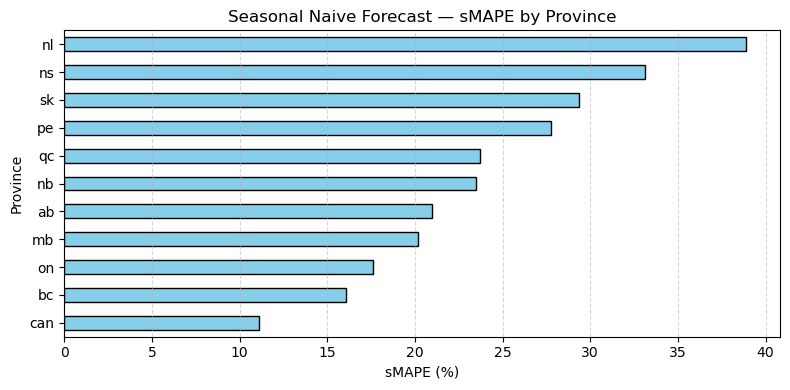

In [12]:
plt.figure(figsize=(8, 4))
prov_metrics_naive["sMAPE"].sort_values().plot(kind="barh", color="skyblue", edgecolor="black")
plt.xlabel("sMAPE (%)")
plt.ylabel("Province")
plt.title("Seasonal Naive Forecast — sMAPE by Province")
plt.grid(axis="x", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

In [13]:
#Linear Regression

def linreg_metrics_by_province(train_df, test_df, features, target="dwelling_starts"):
    rows = []
    for prov, gtrain in train_df.groupby("province"):
        gtest = test_df[test_df["province"] == prov]
        if gtest.empty:
            continue
        # Train model for this province
        X_train = gtrain[features]
        y_train = gtrain[target]
        X_test  = gtest[features]
        y_test  = gtest[target]

        model = LinearRegression()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        res = metrics(y_test, y_pred)   # your existing metrics() function
        res["province"] = prov
        rows.append(res)
    return pd.DataFrame(rows).set_index("province")

In [14]:
prov_linreg = linreg_metrics_by_province(train, test, features=feat_cols)
print(prov_linreg)
print("\nAverage across provinces:\n", prov_linreg.mean())

                  MAE         RMSE      sMAPE
province                                     
ab        1272.716598  1632.083965  15.718879
bc        1903.035802  2386.843666  17.537872
can       6507.799561  8721.436550  11.088168
mb         441.912264   546.182168  22.938173
nb         313.889919   388.782728  28.975698
nl         145.775373   184.923962  41.457633
ns         458.897522   624.460551  27.730794
on        3295.982069  3820.706781  16.266375
pe          77.547012   104.586431  26.204537
qc        2706.494383  3340.811747  20.808809
sk         290.405252   349.936782  27.773423

Average across provinces:
 MAE      1583.132341
RMSE     2009.159575
sMAPE      23.318215
dtype: float64


In [15]:
y_train = train["dwelling_starts"]
y_true  = test["dwelling_starts"]

In [16]:
MODEL_REGISTRY = {
    "lr": lambda **kw: LinearRegression(**kw),
    "rf": lambda **kw: RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1, **kw),
    "ridge": lambda **kw: Ridge(alpha=1.0, **kw),
    "xgb": lambda **kw: XGBRegressor(n_estimators=300, learning_rate=0.05, random_state=42, **kw),
    "enet":  lambda **kw: ElasticNet(alpha=1e-3, l1_ratio=0.5, max_iter=10000, **kw),
    "huber": lambda **kw: HuberRegressor(epsilon=1.35, **kw),

    # gradient boosting (fast, strong)
    "hgb":   lambda **kw: HistGradientBoostingRegressor(learning_rate=0.05, max_depth=None, **kw),
}

def run_model(name, train, test, features, target="dwelling_starts", per_province=False, **model_kwargs):
    model = MODEL_REGISTRY[name](**model_kwargs)
    if not per_province:
        Xtr, ytr = train[features], train[target]
        Xte, yte = test[features],  test[target]
        model.fit(Xtr, ytr)
        ypred = model.predict(Xte)
        return ypred, metrics(yte, ypred)  # uses your existing metrics()
    else:
        rows = []
        for prov, gtr in train.groupby("province"):
            gte = test[test["province"] == prov]
            if gte.empty: 
                continue
            m = MODEL_REGISTRY[name](**model_kwargs)
            Xtr, ytr = gtr[features], gtr[target]
            Xte, yte = gte[features], gte[target]
            m.fit(Xtr, ytr)
            ypred = m.predict(Xte)
            res = metrics(yte, ypred)
            res["province"] = prov
            rows.append(res)
        import pandas as pd
        return pd.DataFrame(rows).set_index("province")


In [27]:
models = ['lr', 'rf', 'ridge', 'xgb', 'enet']

In [28]:
rows = []
for prov, gtr in train.groupby("province"):
    gte = test[test["province"] == prov]
    if gte.empty: 
        continue
    y_train = gtr["dwelling_starts"]
    y_true  = gte["dwelling_starts"]
    for name in models:
        m = MODEL_REGISTRY[name]()  # build model
        Xtr, Xte = gtr[feat_cols], gte[feat_cols]
        m.fit(Xtr, y_train)
        y_pred = m.predict(Xte)
        row = metrics(y_true, y_pred)  # MAE/RMSE/sMAPE
        row["MASE"] = mase(y_true, y_pred, y_train, season=4)
        row["model"] = name
        row["province"] = prov
        rows.append(row)
prov_cmp = pd.DataFrame(rows).set_index(["province","model"])
print(prov_cmp)

                        MAE          RMSE      sMAPE      MASE
province model                                                
ab       lr     1272.716598   1632.083965  15.718879  0.876480
         rf     1939.142515   2428.917390  22.395416  1.335427
         ridge  1272.716598   1632.083965  15.718879  0.876480
         xgb    2019.650843   2598.172150  23.826421  1.390870
         enet   1272.716598   1632.083965  15.718879  0.876480
bc       lr     1903.035802   2386.843666  17.537872  1.416539
         rf     2119.028596   2531.457217  19.546595  1.577315
         ridge  1903.035802   2386.843667  17.537872  1.416539
         xgb    2022.632174   2468.380630  18.785821  1.505562
         enet   1903.035802   2386.843666  17.537872  1.416539
can      lr     6507.799561   8721.436550  11.088168  1.360953
         rf     7896.586049   9544.301785  13.386689  1.651385
         ridge  6507.799561   8721.436550  11.088168  1.360953
         xgb    8800.806617  10286.965793  15.190361  1